In [0]:
from PIL import Image
import pandas as pd
import numpy as np
import matplotlib
import matplotlib.pyplot as plt
import warnings
warnings.simplefilter('ignore')
np.random.seed(12345)
import os
from torchvision import transforms
from torch.utils.data import DataLoader
import torch
from torch import nn
from torchvision import models
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, confusion_matrix
import seaborn as sns
device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')

In [0]:
def plot_tensor(tns):
    plt.figure(figsize=(10,10))
    plt.axis('off')
    plt.imshow(tns.permute(1, 2, 0))
    plt.show()
    plt.savefig('tensor.png')

def plot_heatmap(matrix):
    plt.figure(figsize=(10,10))
    sns.heatmap(matrix, cmap='YlOrBr', xticklabels=True, yticklabels=True, annot=True, fmt='g', vmax=100)
    plt.show()
    plt.savefig('matrix.png')

In [4]:
device

device(type='cuda', index=0)

In [0]:
def classes(key):
    base_dict = {
        'without_mask': 0,
        'with_mask': 1,
    }
    revd = dict([reversed(i) for i in base_dict.items()])
    base_dict.update(revd)
    return base_dict[key]

In [0]:
data_transform = {
    'train': transforms.Compose([
        transforms.RandomRotation(360),
        transforms.Resize(256),
        transforms.RandomResizedCrop(224, scale=(0.8, 1.0)),
        transforms.RandomChoice([
            transforms.RandomHorizontalFlip(),
            transforms.RandomVerticalFlip(),
            transforms.RandomPerspective(distortion_scale=0.1),
            transforms.RandomAffine(10)
        ]),
        transforms.RandomChoice([
            transforms.ColorJitter(brightness=0.2, contrast=0.2, saturation=0.3, hue=0.1),
            transforms.RandomGrayscale(p=0.5)
        ]),
        transforms.ToTensor(),
        transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
    ]),
    'val': transforms.Compose([
        transforms.Resize((256,256)),
        transforms.ToTensor(),
        transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
    ]),
}

In [0]:
class MascarillasDataset(torch.utils.data.Dataset):

    def __init__(self, path='/content/drive/My Drive/data/all/', anns_df=None, tnfs=None):

        image_ids = anns_df['filename'].values
        targets = np.array([int(classes(x)) for x in anns_df['class'].values])

        self.tnfs = tnfs
        self.image_ids = image_ids
        
        self.targets = targets
        self.path = path

    def __getitem__(self, idx):

        picture_id = self.image_ids[idx]
        image = Image.open(self.path + picture_id)

        if self.tnfs is not None:
            image = self.tnfs(image)
        else:
            image = transforms.ToTensor()(image)
            
        target = torch.tensor(self.targets[idx])
        return image, target

    def __len__(self):
        return len(self.image_ids)

In [0]:
def train(model, data_loader, criterion, optimizer, device):            
    model.train()
    model.to(device)
    running_loss = 0.
    running_acc = 0.
       
    for inputs, labels in data_loader:
        inputs = inputs.to(device)
        labels = labels.to(device)
                
        optimizer.zero_grad()
        outputs = model(inputs)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()
           
        _, preds = torch.max(outputs, 1)
        
        running_loss += loss.item() * inputs.size(0)
        running_acc += torch.sum(preds == labels.data)
                
    running_loss /= len(data_loader.dataset)
    running_acc /= len(data_loader.dataset)
                
    return running_loss, running_acc 

In [0]:
def validate(model, data_loader, criterion, device):
    model.eval()
    model.to(device)
    running_loss = 0.
    running_acc = 0.
       
    for inputs, labels in data_loader:
        inputs = inputs.to(device)
        labels = labels.to(device)
                        
        outputs = model(inputs)
        loss = criterion(outputs, labels)
           
        _, preds = torch.max(outputs, 1)
        
        running_loss += loss.item() * inputs.size(0)
        running_acc += torch.sum(preds == labels.data)
                
    running_loss /= len(data_loader.dataset)
    running_acc /= len(data_loader.dataset)
                
    return running_loss, running_acc

In [11]:
model = models.resnet18(pretrained=True)

Downloading: "https://download.pytorch.org/models/resnet18-5c106cde.pth" to /root/.cache/torch/checkpoints/resnet18-5c106cde.pth


In [0]:
for p in model.parameters():
    p.requires_grad = False

In [0]:
in_features = model.fc.in_features
num_classes = 2

In [0]:
model.fc = nn.Linear(in_features, num_classes)

In [0]:
parameters_to_update = [p for p in model.parameters() if p.requires_grad]

In [0]:
batch_size = 8
num_workers = 8

In [0]:
df_data = pd.read_csv('/content/drive/My Drive/data/test.csv')
df_data2 = pd.read_csv('/content/drive/My Drive/data/train.csv')

In [0]:
df = pd.concat([df_data,df_data2])

In [0]:
df = df[~df.filename.agg(lambda x: 'augmented' in x) | ~df['class'].agg(lambda x: 'without_mask' == x) ]

In [0]:
metadata = df

In [0]:
train_df, val_df = train_test_split(metadata, test_size=0.2, stratify=metadata['class'].values)

In [0]:
data = {
    'train': MascarillasDataset(tnfs=data_transform['train'], anns_df=train_df),
    'val': MascarillasDataset(tnfs=data_transform['val'], anns_df=val_df),
} 

In [0]:
data_loader = {
    'train': DataLoader(data['train'], batch_size=batch_size, shuffle=True, num_workers=num_workers),
    'val': DataLoader(data['val'], batch_size=batch_size, shuffle=False, num_workers=num_workers)
}

In [0]:
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(parameters_to_update, lr=0.0001)

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

In [25]:
model.to(device)

ResNet(
  (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace=True)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    )
    (1): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
  

In [0]:
num_epochs = 30
train_losses = []
val_losses = []
train_accs = []
val_accs = []

In [27]:
for epoch in range(1, num_epochs+1):
        train_loss, train_acc = train(model, data_loader['train'], criterion, optimizer, device)
        
        val_loss, val_acc = validate(model, data_loader['val'], criterion, device)
        
        train_losses.append(train_loss)
        val_losses.append(val_loss)
        train_accs.append(train_acc)
        val_accs.append(val_acc)

        print('[{}] loss: train={:.3f}, val={:.3f} -- accuracy: train={:.3f}, val={:.3f}'.format(epoch, train_loss, val_loss, train_acc, val_acc))

[1] loss: train=0.610, val=0.578 -- accuracy: train=0.658, val=0.717
[2] loss: train=0.502, val=0.461 -- accuracy: train=0.773, val=0.808
[3] loss: train=0.419, val=0.405 -- accuracy: train=0.851, val=0.890
[4] loss: train=0.376, val=0.352 -- accuracy: train=0.882, val=0.932
[5] loss: train=0.333, val=0.323 -- accuracy: train=0.902, val=0.890
[6] loss: train=0.316, val=0.274 -- accuracy: train=0.909, val=0.936
[7] loss: train=0.304, val=0.254 -- accuracy: train=0.918, val=0.959
[8] loss: train=0.268, val=0.245 -- accuracy: train=0.931, val=0.959
[9] loss: train=0.253, val=0.222 -- accuracy: train=0.927, val=0.973
[10] loss: train=0.233, val=0.205 -- accuracy: train=0.938, val=0.977
[11] loss: train=0.242, val=0.204 -- accuracy: train=0.929, val=0.973
[12] loss: train=0.234, val=0.187 -- accuracy: train=0.930, val=0.977
[13] loss: train=0.210, val=0.180 -- accuracy: train=0.944, val=0.973
[14] loss: train=0.204, val=0.177 -- accuracy: train=0.941, val=0.982
[15] loss: train=0.227, val=0

In [0]:
path = '/content/drive/My Drive/'

In [0]:
MODEL_NAME = path+'mascarillas.0001lr_4bs'
torch.save(model.state_dict(), MODEL_NAME)

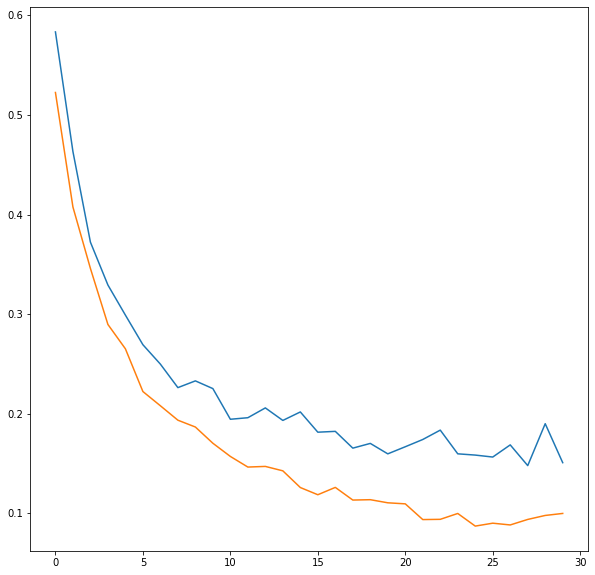

<Figure size 432x288 with 0 Axes>

In [0]:
plt.figure(figsize=(10,10))
plt.plot(train_losses)
plt.plot(val_losses)
plt.show()
plt.savefig('loss.png')

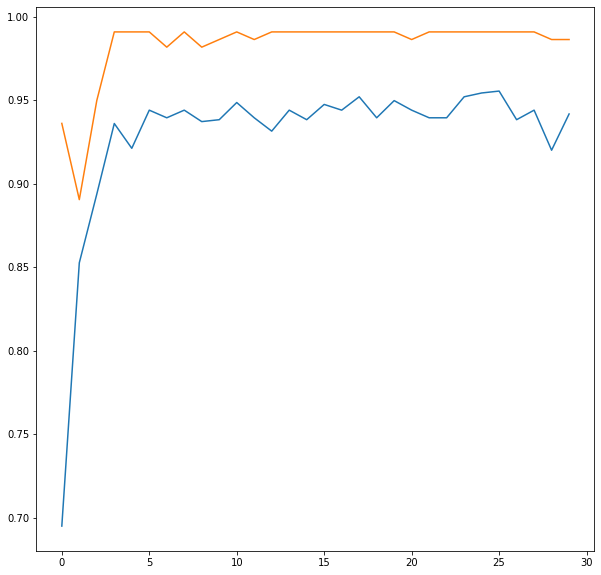

<Figure size 432x288 with 0 Axes>

In [0]:
plt.figure(figsize=(10,10))
plt.plot(train_accs)
plt.plot(val_accs)
plt.show()
plt.savefig('train.png')

In [0]:
model = models.resnet152(pretrained=True)
in_features = model.fc.in_features
num_classes = 2
model.fc = nn.Linear(in_features, num_classes)
model.load_state_dict(torch.load(MODEL_NAME))
model.eval()

ResNet(
  (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace=True)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): Bottleneck(
      (conv1): Conv2d(64, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv3): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (bn3): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (downsample): Sequential(
        (0): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 

In [0]:
def validate_results(model, data_loader, device):
    model.eval()
    model.to(device)
    labels_arr = np.empty((0,1))
    predictions = np.empty((0,1))
    for inputs, labels in data_loader:
        inputs = inputs.to(device)
        outputs = model(inputs)
        _, preds = torch.max(outputs, 1)
        predictions = np.vstack([predictions, np.expand_dims(preds.cpu().detach().numpy(), axis=1)])
        labels_arr = np.vstack([labels_arr, np.expand_dims(labels.cpu().detach().numpy(), axis=1)])
    return labels_arr, predictions

              precision    recall  f1-score   support

         0.0       0.96      1.00      0.98        82
         1.0       1.00      0.98      0.99       137

    accuracy                           0.99       219
   macro avg       0.98      0.99      0.99       219
weighted avg       0.99      0.99      0.99       219



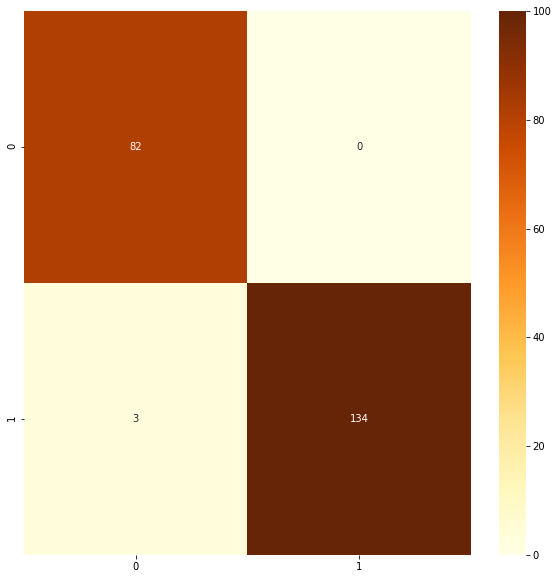

<Figure size 432x288 with 0 Axes>

In [0]:
labels_arr, predictions = validate_results(model, data_loader['val'], device)
print(classification_report(labels_arr, predictions))
cm = confusion_matrix(labels_arr, predictions, labels=[0,1])
plot_heatmap(cm)

In [0]:
def get_prediction(image_bytes):
    tensor = transform_image(image_bytes)
    outputs = model.forward(tensor)
    _, y_hat = outputs.max(1)
    predicted_idx = int(y_hat.item())
    class_names=['without_mask','with_mask']
    return class_names[predicted_idx]

In [0]:
from PIL import Image
img = Image.open(path+'data/all/1.jpg')

In [0]:
def transform_image(image_bytes):
    prediction_transform = transforms.Compose([transforms.Resize(size=(224, 224)),
                                               transforms.ToTensor(), 
                                               transforms.Normalize(mean=[0.485, 0.456, 0.406],
                                                                    std=[0.229, 0.224, 0.225])])
    image = Image.open(image_bytes).convert('RGB')
    return prediction_transform(image)[:3,:,:].unsqueeze(0)

In [0]:
prediction_transform = transforms.Compose([transforms.Resize(size=(224, 224)),
                                               transforms.ToTensor(), 
                                               transforms.Normalize(mean=[0.485, 0.456, 0.406],
                                                                    std=[0.229, 0.224, 0.225])])

In [0]:
image = Image.open(path+'data/all/1.jpg').convert('RGB')

In [0]:
model.to(device)

ResNet(
  (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace=True)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): Bottleneck(
      (conv1): Conv2d(64, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv3): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (bn3): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (downsample): Sequential(
        (0): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 

In [0]:
get_prediction(path+'data/all/1.jpg')

RuntimeError: ignored